Refer:
https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html

and
https://www.youtube.com/watch?v=f-JCCOHwx1c

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [ ]:
#learn the extrac and load part now just direct downloading
!!curl -O http://www.manythings.org/anki/hin-eng.zip
!!unzip hin-eng.zip

['Archive:  hin-eng.zip',
 '  inflating: hin.txt                 ',
 '  inflating: _about.txt              ']

In [ ]:
batch_size=256
epochs=300
latent_dim=64
num_samples=900
data_path='/content/hin.txt'
#In an LSTM, the hidden state is a vector that holds information about the sequence it has processed so far. The latent dimension specifies the length of this vector.
#For example, if the latent dimension is set to 64, each LSTM cell's hidden state is represented as a 64-dimensional vector at every time step

In [ ]:
input_texts = []#to hold all input texts(eng)
target_texts = []#to hold all output texts(hin)
#both to get the unique in each
input_characters = set()
target_characters = set()

with open(data_path,'r',encoding = 'utf-8') as f:
  lines = f.read().split('\n')#reading all lines

for line in lines[: min(num_samples, len(lines)-1)]:
  #for each line take the input text and target text then for each add the unique characters
  input_text,target_text,_ = line.split('\t') #so divide based on a tab space one at end is there ignore that
  #Now to the target_text i.e hinde add start and end with \t and \n so can easily identify
  target_text = '\t' + target_text + '\n'

  #now append
  input_texts.append(input_text)
  target_texts.append(target_text)

  #now append the characters and only the unique ones
  for char in input_text:
    if char not in input_characters:
      input_characters.add(char)#add as set
  for char in target_text:#same for target text
    if char not in target_characters:
      target_characters.add(char)

In [ ]:
input_texts[:20]

['Wow!',
 'Duck!',
 'Duck!',
 'Help!',
 'Jump.',
 'Jump.',
 'Jump.',
 'Hello!',
 'Hello!',
 'Cheers!',
 'Cheers!',
 'Exhale.',
 'Exhale.',
 'Got it?',
 "I'm OK.",
 'Inhale.',
 'Inhale.',
 'Thanks!',
 'We won.',
 'Awesome!']

In [ ]:
input_characters#all the unique characters in the input texts

{' ',
 '!',
 '"',
 "'",
 ',',
 '-',
 '.',
 '0',
 '1',
 '3',
 '5',
 '6',
 '7',
 '8',
 '9',
 ':',
 '?',
 'A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'R',
 'S',
 'T',
 'U',
 'W',
 'Y',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 '€'}

In [ ]:
target_texts[:10]

['\tवाह!\n',
 '\tझुको!\n',
 '\tबतख़!\n',
 '\tबचाओ!\n',
 '\tउछलो.\n',
 '\tकूदो.\n',
 '\tछलांग.\n',
 '\tनमस्ते।\n',
 '\tनमस्कार।\n',
 '\tवाह-वाह!\n']

In [ ]:
target_characters

{'\t',
 '\n',
 ' ',
 '!',
 '"',
 ',',
 '-',
 '.',
 '0',
 '1',
 '7',
 '9',
 '?',
 'I',
 'ँ',
 'ं',
 'अ',
 'आ',
 'इ',
 'ई',
 'उ',
 'ऊ',
 'ए',
 'ऐ',
 'ओ',
 'औ',
 'क',
 'ख',
 'ग',
 'घ',
 'च',
 'छ',
 'ज',
 'झ',
 'ञ',
 'ट',
 'ठ',
 'ड',
 'ढ',
 'ण',
 'त',
 'थ',
 'द',
 'ध',
 'न',
 'प',
 'फ',
 'ब',
 'भ',
 'म',
 'य',
 'र',
 'ल',
 'व',
 'श',
 'ष',
 'स',
 'ह',
 '़',
 'ा',
 'ि',
 'ी',
 'ु',
 'ू',
 'ृ',
 'ॅ',
 'े',
 'ै',
 'ॉ',
 'ो',
 'ौ',
 '्',
 '।',
 '०',
 '१',
 '५',
 '६',
 '७',
 '८',
 '९',
 '€'}

1) Turn the sentences into 3 Numpy arrays,

encoder_input_data, decoder_input_data, decoder_target_data:

encoder_input_data is a 3D array of shape (num_pairs, max_english_sentence_length, num_english_characters) containing a one-hot vectorization of the English sentences.

decoder_input_data is a 3D array of shape (num_pairs, max_french_sentence_length, num_french_characters) containg a one-hot vectorization of the French sentences.

decoder_target_data is the same as decoder_input_data but offset by one timestep. decoder_target_data[:, t, :] will be the same as decoder_input_data[:, t + 1, :].

In [ ]:
input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
#so sort both

num_encoder_tokens = len(input_characters)#so len of unique
num_decoder_tokens = len(target_characters)

#so get the max length of both
max_encoder_seq_length = max([len(x) for x in input_texts])
max_decoder_seq_length = max([len(x) for x in target_texts])

#so all these are required for representing encoder input,decoder input and decoder target also

In [ ]:
print(num_samples)#this is the num of pairs
print(num_encoder_tokens) #this is num_engilish_characters
print(num_decoder_tokens) #this is num_hindi_characters
print(max_encoder_seq_length)#this is max english sentence length
print(max_decoder_seq_length)#of hindi

900
66
81
24
60


In [ ]:
#now we associate each char the index and make a dict
input_token_dict = dict(
    [(char,i) for i,char in enumerate(input_characters)]
)

target_token_dict = dict(
    [(char,i) for i,char in enumerate(target_characters)]
)
input_token_dict

{' ': 0,
 '!': 1,
 '"': 2,
 "'": 3,
 ',': 4,
 '-': 5,
 '.': 6,
 '0': 7,
 '1': 8,
 '3': 9,
 '5': 10,
 '6': 11,
 '7': 12,
 '8': 13,
 '9': 14,
 ':': 15,
 '?': 16,
 'A': 17,
 'B': 18,
 'C': 19,
 'D': 20,
 'E': 21,
 'F': 22,
 'G': 23,
 'H': 24,
 'I': 25,
 'J': 26,
 'K': 27,
 'L': 28,
 'M': 29,
 'N': 30,
 'O': 31,
 'P': 32,
 'R': 33,
 'S': 34,
 'T': 35,
 'U': 36,
 'W': 37,
 'Y': 38,
 'a': 39,
 'b': 40,
 'c': 41,
 'd': 42,
 'e': 43,
 'f': 44,
 'g': 45,
 'h': 46,
 'i': 47,
 'j': 48,
 'k': 49,
 'l': 50,
 'm': 51,
 'n': 52,
 'o': 53,
 'p': 54,
 'q': 55,
 'r': 56,
 's': 57,
 't': 58,
 'u': 59,
 'v': 60,
 'w': 61,
 'x': 62,
 'y': 63,
 'z': 64,
 '€': 65}

In [ ]:
#now to do the representation of 3d for each first put all zeros that above wala refer to see for each ka
encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
    dtype = 'float32'
)
decoder_input_data = np.zeros(
    (len(target_texts), max_decoder_seq_length,num_decoder_tokens),
    dtype = 'float32'
)
decoder_target_data = np.zeros(
    (len(target_texts), max_decoder_seq_length,num_decoder_tokens),
    dtype = 'float32'
)#this is same as decoder input just change is in offset this is decoder output actually

In [ ]:
#now do the one hot encoding so for each char in input text in that i of input text we go on to put 1 same for target text also

for i,(input_text,target_text) in enumerate(zip(input_texts,target_texts)): #so enumerate gives us index just that
  for t,char in enumerate(input_text): #here t is index and char is actual char in the input_text
    #so just at that pos put 1 in the encoder_input_data
    encoder_input_data[i,t,input_token_dict[char]] = 1 #so use of dict which we created above used here
  #once done then a space where is there there we put 1
  encoder_input_data[i,t+1:,input_token_dict[' ']] = 1

  #now for decoder
  for t,char in enumerate(target_text):
    decoder_input_data[i,t,target_token_dict[char]] = 1
    #now for the target of decoder which is ahead and wont contain the start token
    if t > 0:
      decoder_target_data[i,t-1,target_token_dict[char]] = 1
  #once done then a space
  decoder_input_data[i,t+1:,target_token_dict[' ']] = 1
  decoder_target_data[i,t:,target_token_dict[' ']] = 1

#basically it is for each sequence(input) for each char the one hot encoding of it wrt the input_token_dict meaning each char ohe of unique input characters

Your approach to performing one-hot encoding for `encoder_input_data`, `decoder_input_data`, and `decoder_target_data` looks conceptually correct. However, I'll walk you through the logic to ensure everything is clear and address any potential issues.

### Explanation of Your Code:
1. **Enumerating `input_texts` and `target_texts`**:
   - `for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):`:
     - `i` is the index for each sentence pair.
     - `input_text` is the source (Hindi) sentence.
     - `target_text` is the target (English) sentence.
   
2. **One-Hot Encoding `encoder_input_data`**:
   - `for t, char in enumerate(input_text):`:
     - `t` is the index for each character in `input_text`.
     - `char` is the character at position `t` in `input_text`.
   - `encoder_input_data[i, t, input_token_dict[char]] = 1`:
     - Sets the position `(i, t, input_token_dict[char])` in `encoder_input_data` to 1, where `input_token_dict` maps each character to its index in the character set.

   - `encoder_input_data[i, t+1:, input_token_dict[' ']] = 1`:
     - This fills the remaining positions after the last character in `input_text` with the one-hot encoding for a space character. This step pads sequences with spaces, which may not be needed unless specifically required by your model setup.

3. **One-Hot Encoding `decoder_input_data` and `decoder_target_data`**:
   - `for t, char in enumerate(target_text):`:
     - Similar to the encoder loop, `t` is the index, and `char` is the character at position `t` in `target_text`.
   - `decoder_input_data[i, t, target_token_dict[char]] = 1`:
     - Sets the position `(i, t, target_token_dict[char])` in `decoder_input_data` to 1.
   - `if t > 0: decoder_target_data[i, t-1, target_token_dict[char]] = 1`:
     - Offsets the one-hot assignment by one position for `decoder_target_data`, ensuring that the output target is one step ahead (for teacher forcing during training).
   - `decoder_input_data[i, t+1:, target_token_dict[' ']] = 1` and `decoder_target_data[i, t:, target_token_dict[' ']] = 1`:
     - These lines fill the remaining positions after the last character with the one-hot encoding for a space character, similar to the encoder padding.

### Points to Consider:
- **Padding with Spaces**: Adding spaces (`' '`) to pad sequences may or may not be necessary depending on how your model handles padding. Ensure that your model architecture can process padded sequences correctly, or use an appropriate masking mechanism.
- **Boundary Conditions**: Check that `t + 1:` does not exceed the predefined maximum length of `encoder_input_data` and `decoder_input_data`. This is generally controlled by the maximum length of your sequences.
- **Efficiency**: Filling all remaining positions with a space after the last character works but may be unnecessary if you handle padding differently (e.g., using `numpy`'s default zero padding).

### Correctness:
The logic in your code is sound for creating one-hot encoded data matrices for training a seq2seq model. It maps each character in `input_texts` and `target_texts` to its respective one-hot position. Make sure your dictionaries (`input_token_dict` and `target_token_dict`) cover all unique characters in `input_texts` and `target_texts` for smooth operation.

### Suggestion:
If you're certain that your model does not need trailing spaces filled after the last character, you could remove the `t+1:` lines for a cleaner approach. If padding is required, using `' '` as a placeholder is fine as long as your tokenizer and model know how to handle it.

In [ ]:
encoder_input_data[0]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)

### Now Define the encoder and decoder
##### Train a basic LSTM-based Seq2Seq model to predict decoder_target_data given encoder_input_data and decoder_input_data. Our model uses teacher forcing.

This is our training model. It leverages three key features of Keras RNNs:

The return_state contructor argument, configuring a RNN layer to return a list where the first entry is the outputs and the next entries are the internal RNN states. This is used to recover the states of the encoder.

The inital_state call argument, specifying the initial state(s) of a RNN. This is used to pass the encoder states to the decoder as initial states.

The return_sequences constructor argument, configuring a RNN to return its full sequence of outputs (instead of just the last output, which the defaults behavior). This is used in the decoder.

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,LSTM,Dense

encoder_inputs = Input(shape = (None,num_encoder_tokens))#says take varied input length but each char has num_econder_tokens basically each char is ohe so

encoder = LSTM(latent_dim,return_state=True)
#so here latent dim i.e to have that many neurnons basically what we put as normal neurons as 32 and all
#no return sequences as output we dont need and return_state = True so to get the last state from lstm
encoder_outputs,state_h,state_c = encoder(encoder_inputs)

encoder_states = [state_h,state_c] #so dont need encoder outputs so only this

decoder_inputs = Input(shape = (None, num_decoder_tokens)) #same here decoder i.e ohe with unique decoder characters

decoder = LSTM(latent_dim,return_sequences=True,return_state=True) #here return seq also as we need to get each step output

decoder_outputs,_,_ = decoder(decoder_inputs,initial_state = encoder_states)#so here we need only decoder_outputs and
#The LSTM is initialized with the encoder's final hidden and cell states. This step allows the decoder to start its predictions with the context
#provided by the encoder.

decoder_dense = Dense(num_decoder_tokens,activation = 'softmax')#so since any among the unique target ka we do that and softmax
decoder_outputs = decoder_dense(decoder_outputs)


Certainly! Let's break down the code block step by step, as it describes the architecture for the **encoder-decoder model** using LSTM layers, which is typically used for **sequence-to-sequence (seq2seq) tasks**, such as machine translation.

### 1. Encoder Setup
```python
encoder_inputs = Input(shape=(None, num_encoder_tokens))
```
- **`Input` Layer**: Defines the input layer for the encoder. The input shape is `(None, num_encoder_tokens)`, meaning it expects variable-length sequences (`None` for the time dimension) where each time step has `num_encoder_tokens` features (one-hot encoded vectors for each character in the input sentence).
- This is the placeholder for the input data that will be fed into the model.

```python
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
```
- **`LSTM` Layer**: The LSTM layer for the encoder has a `latent_dim` size, which specifies the number of units (neurons) in the LSTM cell.
- **`return_state=True`**: Indicates that the LSTM layer should return its last hidden state (`state_h`) and cell state (`state_c`). This is crucial for passing information from the encoder to the decoder.
- **Outputs**:
  - `encoder_outputs`: The LSTM outputs for each time step (not used here).
  - `state_h`: The last hidden state of the LSTM.
  - `state_c`: The last cell state of the LSTM.
- **Purpose**: The hidden state and cell state capture the context of the input sequence and are passed to the decoder to initialize it.

```python
encoder_states = [state_h, state_c]
```
- **Encoder States**: The final hidden state and cell state are stored in `encoder_states`, which will be used to initialize the decoder's LSTM layer. These states represent the "context vector" and summarize the input sequence information.

### 2. Decoder Setup
```python
decoder_inputs = Input(shape=(None, num_decoder_tokens))
```
- **`Input` Layer**: Defines the input for the decoder. The shape `(None, num_decoder_tokens)` means it takes variable-length sequences as input, where each time step has `num_decoder_tokens` features (one-hot encoded vectors for each character in the target sentence).
- This layer is the placeholder for the target data fed into the model during training (typically shifted sequences of the target).

```python
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
```
- **`LSTM` Layer for Decoder**:
  - The `decoder_lstm` is an LSTM layer with the same `latent_dim` size as the encoder.
  - **`return_sequences=True`**: Ensures that the decoder outputs the full sequence of predictions at each time step.
  - **`return_state=True`**: The decoder LSTM returns not only the output sequence but also its last hidden and cell states. However, these states (`_, _`) are not used during training but are needed during inference for generating subsequent sequences.
  - **`initial_state=encoder_states`**: The LSTM is initialized with the encoder's final hidden and cell states. This step allows the decoder to start its predictions with the context provided by the encoder.

```python
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)
```
- **`Dense` Layer**:
  - A fully connected (`Dense`) layer is applied to each time step of the decoder's output.
  - **`num_decoder_tokens`**: The number of output units matches the number of possible tokens (characters or words) in the target language.
  - **`activation='softmax'`**: Applies a softmax activation function to output probabilities for each possible token, ensuring that each time step's output is a probability distribution over the target vocabulary.

### Summary:
- **Encoder**:
  - Processes the input sequence and returns its last hidden and cell states (`state_h`, `state_c`).
- **Decoder**:
  - Takes the target sequence (shifted by one step) as input and uses the encoder's final states as its initial states.
  - Produces output sequences by predicting the next token at each time step.
  - Outputs from the `Dense` layer represent probabilities for each token in the target language.

### Key Concepts:
- **Encoder-Decoder Model**: A type of seq2seq model where the encoder summarizes the input into a context vector (hidden states), and the decoder generates the output sequence based on this context.
- **Latent Dimension**: Specifies the size of the LSTM's hidden states, controlling the model's capacity.
- **Teacher Forcing (During Training)**: The decoder receives the actual previous token from the target sequence to predict the next token, enhancing training stability.

Epoch 1/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 245ms/step - accuracy: 0.0946 - loss: 4.3558 - val_accuracy: 0.6269 - val_loss: 4.1835
Epoch 2/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.7007 - loss: 4.0625 - val_accuracy: 0.6373 - val_loss: 3.6211
Epoch 3/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.7073 - loss: 3.2676 - val_accuracy: 0.6375 - val_loss: 2.6701
Epoch 4/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7049 - loss: 2.3342 - val_accuracy: 0.6375 - val_loss: 2.2378
Epoch 5/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.7094 - loss: 1.8903 - val_accuracy: 0.6375 - val_loss: 2.0753
Epoch 6/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7067 - loss: 1.7342 - val_accuracy: 0.6375 - val_loss: 2.0073
Epoch 7/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7078 - loss: 1.6544 - val_accuracy: 0.6375 - val_loss: 1.9633
Epoch 8/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7071 - loss: 1.6109 - val_accuracy: 0.6375 - val_loss

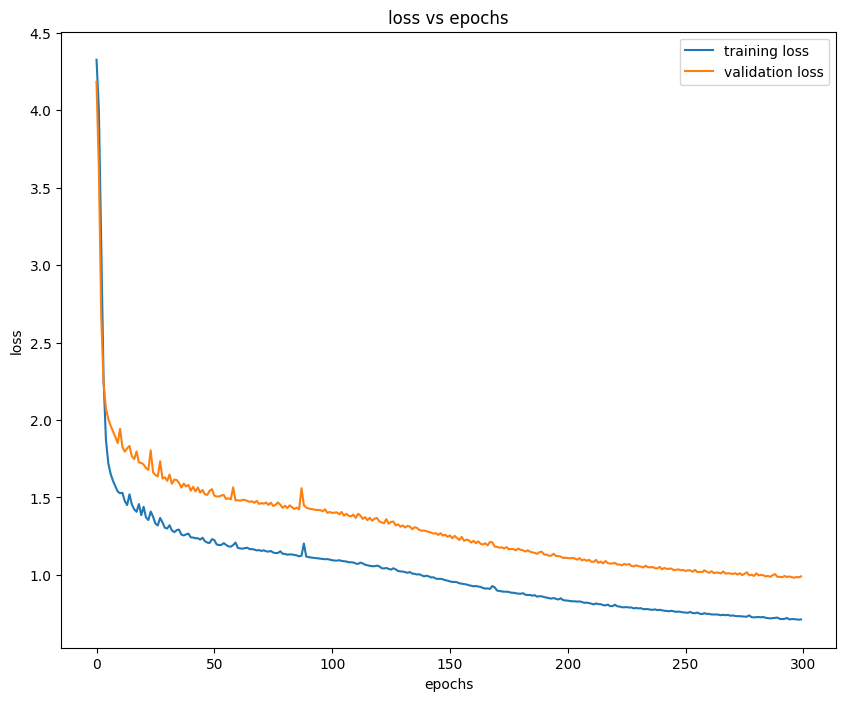

In [ ]:
model = Model([encoder_inputs,decoder_inputs],decoder_outputs)#then create the model using Model api with input and outputs

#now compile
model.compile(optimizer = 'rmsprop', loss ='categorical_crossentropy',metrics = ['accuracy'])
#since each as ohe and many outputs we do categorical crossentory

history = model.fit([encoder_input_data,decoder_input_data],decoder_target_data,batch_size = batch_size,epochs = epochs,validation_split = 0.2)
#so fit the model with the data

#save the model
model.save('s2s_rms_prop.h5')

#plot of the model
plt.figure(figsize = (10,8))
plt.plot(history.history['loss'],label = 'training loss')
plt.plot(history.history['val_loss'],label = 'validation loss')
plt.title('loss vs epochs')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

This part of the code defines and trains the **seq2seq model** for your machine translation task. Let's break down each step and explain the components in detail:

### 1. Defining the Model:
```python
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
```
- **`Model` Class**:
  - This line creates a Keras model instance that takes two inputs (`encoder_inputs` and `decoder_inputs`) and outputs `decoder_outputs`.
  - **Inputs**:
    - `encoder_inputs`: Represents the input data to the encoder (e.g., one-hot encoded characters of the source language).
    - `decoder_inputs`: Represents the input data to the decoder (e.g., one-hot encoded characters of the target language shifted by one time step).
  - **Output**:
    - `decoder_outputs`: The output from the decoder's LSTM layer after being passed through the `Dense` layer with `softmax` activation. This output is a sequence of probability distributions over the target language vocabulary.

### 2. Compiling the Model:
```python
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
```
- **`compile` Method**:
  - **`optimizer='rmsprop'`**:
    - The model uses the **RMSprop** optimizer, which is well-suited for RNNs/LSTMs as it helps maintain a good learning rate throughout training by adapting the learning rate for each parameter.
  - **`loss='categorical_crossentropy'`**:
    - The loss function used is **categorical crossentropy**, which is appropriate for multi-class classification tasks where each output time step needs to predict a single token from a set of possible tokens (i.e., a probability distribution over the target vocabulary).
  - **`metrics=['accuracy']`**:
    - The model will also compute and report **accuracy** during training. Note that this metric checks how many predicted tokens match the actual tokens at each time step, but for sequence generation, more sophisticated evaluation metrics might be needed (e.g., BLEU score).

### 3. Training the Model:
```python
model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2)
```
- **`fit` Method**:
  - **Training Data**:
    - `[encoder_input_data, decoder_input_data]`: The model is trained using two input datasets:
      - `encoder_input_data`: The one-hot encoded input sequences for the encoder.
      - `decoder_input_data`: The one-hot encoded input sequences for the decoder (shifted target sequences).
    - `decoder_target_data`: The expected output data, which the model aims to predict. This data is shifted by one time step relative to `decoder_input_data` for teacher forcing.
  - **`batch_size=batch_size`**:
    - Specifies the number of samples per gradient update. A smaller batch size can lead to more granular updates, while a larger batch size can speed up training.
  - **`epochs=epochs`**:
    - Number of complete passes through the training dataset.
  - **`validation_split=0.2`**:
    - A portion (20%) of the training data is set aside for validation. The model's performance on this validation set is evaluated at the end of each epoch to monitor for potential overfitting.

### Detailed Process:
- **Training**:
  - The `fit` method runs the training loop, where the model's weights are updated using the training data.
  - **Forward Pass**: The model computes the output probabilities for the target sequence given the input sequences.
  - **Loss Calculation**: The categorical crossentropy loss is computed between `decoder_target_data` and the model's predictions (`decoder_outputs`).
  - **Backward Pass**: The optimizer (RMSprop) updates the model weights to minimize the loss.
- **Validation**:
  - After each epoch, the model evaluates its performance on the 20% validation set.
  - This helps monitor the model's generalization and detect overfitting.

### Purpose of this Code:
This code sets up the model's training process to learn a mapping from input sequences (e.g., Hindi sentences) to target sequences (e.g., English sentences). The encoder-decoder architecture, guided by the LSTM layers and one-hot encoded inputs, enables the model to handle variable-length sequences and learn contextual representations for translation tasks.

Epoch 1/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 206ms/step - accuracy: 0.8277 - loss: 0.6577 - val_accuracy: 0.7569 - val_loss: 0.9360
Epoch 2/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8261 - loss: 0.6568 - val_accuracy: 0.7563 - val_loss: 0.9278
Epoch 3/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.8294 - loss: 0.6495 - val_accuracy: 0.7572 - val_loss: 0.9258
Epoch 4/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8275 - loss: 0.6528 - val_accuracy: 0.7592 - val_loss: 0.9241
Epoch 5/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8294 - loss: 0.6444 - val_accuracy: 0.7581 - val_loss: 0.9253
Epoch 6/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.8289 - loss: 0.6450 - val_accuracy: 0.7562 - val_loss: 0.9249
Epoch 7/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8276 - loss: 0.6487 - val_accuracy: 0.7575 - val_loss: 0.9242
Epoch 8/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.8295 - loss: 0.6439 - val_accuracy: 0.7582 - val_loss

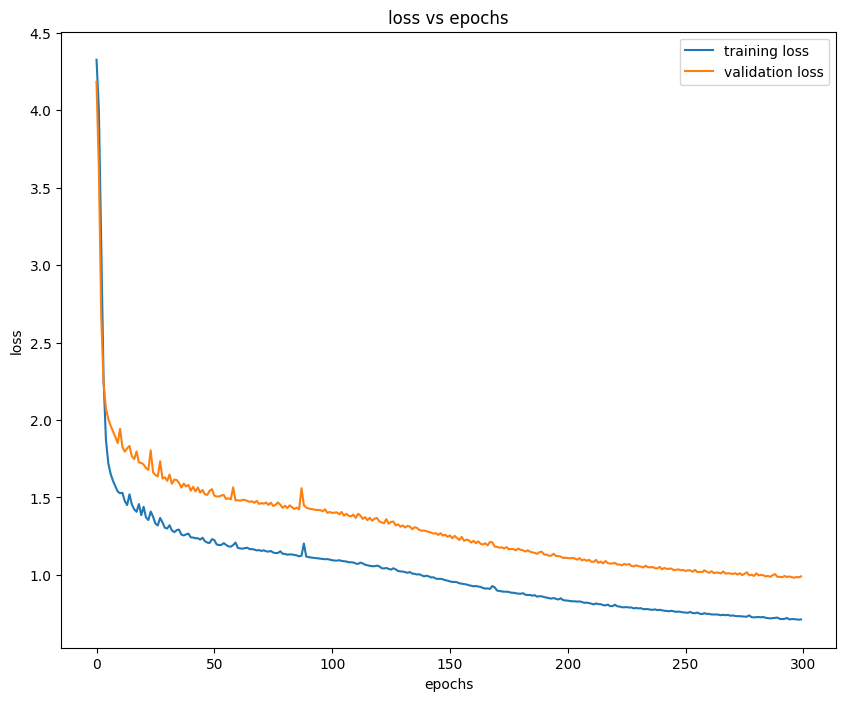

In [ ]:
# Define the model that will turn using adam optimizer & split 0.4
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model1 = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Run training
model1.compile(optimizer='adam', loss='categorical_crossentropy',
              metrics=['accuracy'])
model1.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.4)

#save the model
model1.save('s2s_adam.h5')

#plot the model
plt.figure(figsize=(10,8))
plt.plot(history.history['loss'],label = 'training loss')
plt.plot(history.history['val_loss'],label = 'validation loss')
plt.title('loss vs epochs')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [ ]:
#better accuracy obtained here

### Decoder setup

### Inference Setup
1) Encode the input sentence and retrieve the initial decoder state

2) Run one step of the decoder with this initial state and a "start of
sequence" token as target. The output will be the next target character.

3) Append the target character predicted and repeat.


In [ ]:
# Define sampling models
encoder_model = Model(encoder_inputs, encoder_states)#this encoder model will take encoder inputs and output encoder states(from previous)

decoder_state_input_h = Input(shape=(latent_dim,))#now make the states it will have latent dimension neurons
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder(
    decoder_inputs, initial_state=decoder_states_inputs)#setup decoder and input is same of decoder as previous initial state now is decoder ka
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)#normal dense is done as above
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,#now will take input of decoder input and decoder input states
    [decoder_outputs] + decoder_states)#output will give decoder output and decoder states(this is then used to take context)

# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict(
    (i, char) for char, i in input_token_dict.items())
reverse_target_char_index = dict(
    (i, char) for char, i in target_token_dict.items())


This section of the code is creating separate models for **inference** after training a sequence-to-sequence (seq2seq) model with LSTM layers. The training model is used to learn how to encode and decode sequences, but during inference (generating new sequences), a different approach is needed. Let's go through what each part of this code does:

### 1. **Encoder Model for Inference**
```python
encoder_model = Model(encoder_inputs, encoder_states)
```
- **Purpose**: This line defines the encoder model for inference.
- **Function**: During inference, we need to encode new input sequences into latent states (hidden and cell states of the LSTM). This standalone `encoder_model` accepts an input sequence and outputs the LSTM's hidden and cell states (`encoder_states`).
- **Input**: `encoder_inputs` (the input sequence).
- **Output**: `encoder_states` (the last hidden state `state_h` and cell state `state_c` of the encoder LSTM).

### 2. **Decoder Model Inputs for Inference**
```python
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
```
- **Purpose**: These lines set up placeholders for the decoder's initial states during inference.
- **Function**: During training, the decoder receives initial states from the encoder, but during inference, we need to provide these states explicitly to the decoder. `decoder_state_input_h` and `decoder_state_input_c` will hold the previous hidden and cell states.
- **Input Shape**: The shape matches the latent dimension used in the LSTM (`latent_dim`).

### 3. **Decoder Model for Inference**
```python
decoder_outputs, state_h, state_c = decoder(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
```
- **Purpose**: These lines set up the LSTM decoder for inference.
- **Function**: The `decoder` LSTM layer is reused from the training phase but is set to accept the initial state inputs (`decoder_states_inputs`) and produce:
  - `decoder_outputs`: The output token probabilities for the current timestep.
  - `state_h` and `state_c`: The updated hidden and cell states to be passed to the next timestep.
- **Output**: The output of the decoder is passed through a dense layer (`decoder_dense`) with a softmax activation to generate a probability distribution over the target tokens.

### 4. **Final Decoder Model Definition**
```python
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)
```
- **Purpose**: This defines the complete decoder model for inference.
- **Inputs**:
  - `decoder_inputs`: The input token for the current timestep.
  - `decoder_states_inputs`: The hidden and cell states from the previous timestep.
- **Outputs**:
  - `decoder_outputs`: The output token probabilities.
  - `decoder_states`: The updated hidden and cell states to be fed back in for the next timestep.

### 5. **Reverse-Lookup Dictionaries**
```python
reverse_input_char_index = dict((i, char) for char, i in input_token_dict.items())
reverse_target_char_index = dict((i, char) for char, i in target_token_dict.items())
```
- **Purpose**: These dictionaries are used to map integer indices back to their corresponding characters (or tokens).
- **Function**:
  - `reverse_input_char_index`: Maps from indices to characters for the input language.
  - `reverse_target_char_index`: Maps from indices to characters for the target language.
- **Use Case**: When decoding sequences, these reverse mappings help translate the model's predicted indices back into readable characters or tokens.

### **Summary of Inference Workflow**
1. **Encode** the input sequence using `encoder_model` to obtain initial state vectors (`state_h`, `state_c`).
2. **Initialize** the decoder with the start token and use `decoder_model` to predict the next token.
3. **Update** the input to the decoder with the output token and updated states.
4. **Repeat** the process until an end token is generated or a maximum sequence length is reached.
5. **Decode** the output using `reverse_target_char_index` to construct a human-readable sentence.

This process allows for generating target sequences from unseen input sequences during inference.

In [ ]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)#since now encoder is setup to proivde states as the output that is used here

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))#so create a start of sequence i.e \t to act as first input in inference phase
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_dict['\t']] = 1.#make the ohe of it as 1st seq 1st char with putting 1 in the num_decoder_tokens

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(#output is normal and will have num_of_target_tokens ka as in dense we added that many layers
            [target_seq] + states_value)#so inital will take the input of encoder states and target seq(sos) then the context of decoder is added as state

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])#take the max probability of decoder outputs
        sampled_char = reverse_target_char_index[sampled_token_index]#get the character of it
        decoded_sentence += sampled_char#add to decoder sentence

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True#to stop if eos reached or greater than length

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))#now the new target seq is the one predicted by decoder in previous(since INFERENCE stage else decoder input in previous)
        target_seq[0, 0, sampled_token_index] = 1.#so make ohe of that

        # Update states
        states_value = [h, c]#update the states to be of decoder now

    return decoded_sentence

This function, `decode_sequence`, is designed for the **inference phase** of a sequence-to-sequence model using an LSTM encoder-decoder architecture. It generates an output sentence in the target language given an input sequence in the source language. Here's a detailed breakdown of how the function works:

### Step-by-step Explanation:
1. **Encoding the Input Sequence**:
   - The function receives an input sequence (`input_seq`) in one-hot encoded form.
   - It passes `input_seq` through the trained `encoder_model` using `encoder_model.predict(input_seq)`.
   - This prediction returns the final hidden and cell states of the encoder, `states_value`, which represent the context of the input sequence and are used to initialize the decoder.

2. **Initializing the Target Sequence**:
   - An initial target sequence (`target_seq`) of length 1 is created, initialized as an array of zeros. This acts as the starting input for the decoder.
   - The first element in `target_seq` is set to the one-hot representation of the "start of sequence" character (`\t`), which signals the decoder to start generating an output sequence.

3. **Decoding Loop**:
   - A `while` loop runs until the `stop_condition` is met. This loop generates the output sequence token by token.
   - The decoder model (`decoder_model`) predicts the next token using:
     - The current `target_seq` (starting with the start token initially).
     - The state values from either the encoder (for the first token) or the decoder (for subsequent tokens).
   - The decoder outputs:
     - `output_tokens`: The predicted probabilities of the next character.
     - `h` and `c`: Updated hidden and cell states that will be fed back into the decoder for the next prediction.

4. **Sampling a Token**:
   - The `np.argmax(output_tokens[0, -1, :])` selects the index of the token with the highest probability from the decoder's output.
   - This index is mapped to the actual character using `reverse_target_char_index` to find the `sampled_char`.
   - The `sampled_char` is added to the `decoded_sentence`.

5. **Stop Condition**:
   - The loop stops when:
     - The `sampled_char` is the end-of-sequence character (`\n`).
     - The `decoded_sentence` reaches a length greater than `max_decoder_seq_length` (to prevent infinite loops).

6. **Preparing the Next Input**:
   - A new `target_seq` is prepared with the one-hot encoding of `sampled_char` to be fed as input for the next iteration of the loop.
   - The `states_value` is updated with the current `h` and `c` to maintain the decoder's context.

7. **Return**:
   - The function returns the `decoded_sentence`, which is the final generated sequence in the target language.

### Summary:
- The function starts by encoding the input sequence to get the initial context.
- It uses a loop to generate each subsequent character, feeding the output state back into the decoder to continue generating until a stop condition is met.
- The final output is a sentence decoded from the predicted character tokens.

In [ ]:
for seq_index in range(90):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('Decoded sentence:', decoded_sentence)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
-
Input sentence: Wow!
Decoded sentence: बाहर करो!

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
-
Input sentence: Duck!
Decoded sentence: बार्या ह!

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━

This loop is used to test the trained sequence-to-sequence model on a subset of the input data to see how well it translates input sentences into output sentences. Here's a detailed explanation of the code:

### Step-by-Step Breakdown:
1. **Looping Through a Subset of Data**:
   - The `for` loop iterates over a range of 90 input sequences (`range(90)`). This means that the loop will run 90 times, each time translating a different input sentence.
   - Each `seq_index` represents the index of the sentence being decoded from the training set.

2. **Preparing the Input Sequence**:
   - `input_seq = encoder_input_data[seq_index: seq_index + 1]` extracts a single input sequence from `encoder_input_data`. The `seq_index: seq_index + 1` ensures that `input_seq` has a shape suitable for the model's input, maintaining a batch dimension (e.g., shape `(1, seq_length, num_encoder_tokens)`).

3. **Decoding the Sentence**:
   - `decoded_sentence = decode_sequence(input_seq)` calls the `decode_sequence()` function defined earlier.
   - This function encodes the input sequence, runs the decoder in inference mode to generate the output sequence step by step, and returns the decoded sentence (in the target language).

4. **Printing Results**:
   - `print('-')` outputs a separator line to distinguish results for different sentences.
   - `print('Input sentence:', input_texts[seq_index])` prints the original input sentence from `input_texts` for the current `seq_index`.
   - `print('Decoded sentence:', decoded_sentence)` prints the translated sentence generated by the model.

### What This Does in Practice:
- For each input sentence in the range of 90 sentences:
  - The code retrieves the one-hot encoded input data.
  - It calls the `decode_sequence()` function to translate this input into a sentence in the target language using the trained encoder-decoder models.
  - The original input and the corresponding decoded output are printed for comparison.

### Purpose:
- This step is useful for **evaluating the model's performance** on the training data and observing how accurately it translates sentences. It helps verify that the model is generating reasonable output sentences before testing on unseen data.

### IF GRU

In [ ]:
#It's actually a bit simpler, because GRU has only one state, whereas LSTM has two states. Here's how to adapt the training model to use a GRU layer:


encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = GRU(latent_dim, return_state=True)
encoder_outputs, state_h = encoder(encoder_inputs)

decoder_inputs = Input(shape=(None, num_decoder_tokens))
decoder_gru = GRU(latent_dim, return_sequences=True)
decoder_outputs = decoder_gru(decoder_inputs, initial_state=state_h)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
#the change everywher to have only one state so remove state_c from everywhere

# refer ref notebook for complete

### IF Word level translation has to be done

In [ ]:
# Define an input sequence and process it.
encoder_inputs = Input(shape=(None,))
x = Embedding(num_encoder_tokens, latent_dim)(encoder_inputs)#vocab now is the unique ka len and provide dimensiom to of latent dim
x, state_h, state_c = LSTM(latent_dim,
                           return_state=True)(x)
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))
x = Embedding(num_decoder_tokens, latent_dim)(decoder_inputs)
x = LSTM(latent_dim, return_sequences=True)(x, initial_state=encoder_states)
decoder_outputs = Dense(num_decoder_tokens, activation='softmax')(x)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Compile & run training
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')
# Note that `decoder_target_data` needs to be one-hot encoded,
# rather than sequences of integers like `decoder_input_data`!
model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2)